In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


Import Data Raw

In [96]:
train_dataset = pd.read_csv('train.csv')


In [97]:
train_dataset.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [98]:
train_dataset.columns

Index(['id', 'allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

In [99]:
train_dataset = train_dataset.drop(columns=['id'])

In [100]:
train_dataset.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


Display correlation via HeatMap

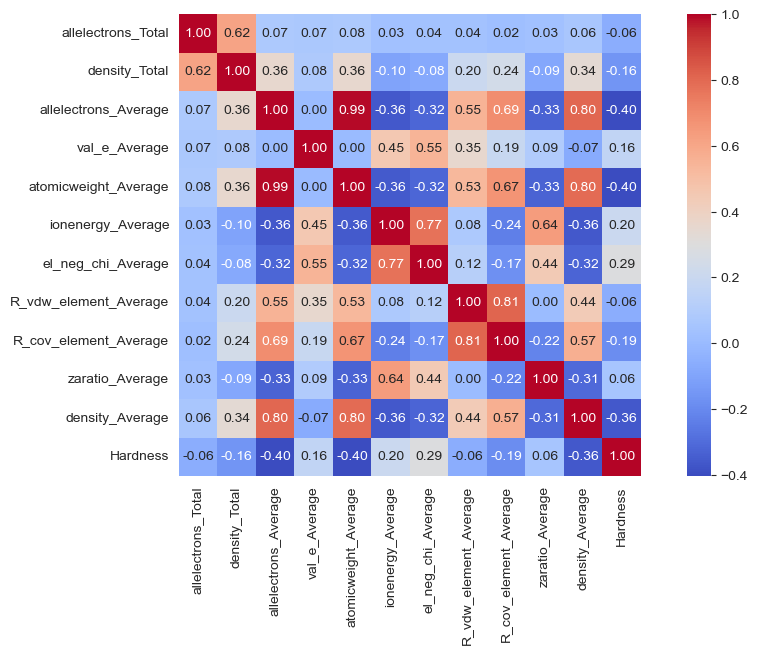

In [101]:
plt.figure(figsize=(12, 6))
plt.imshow(train_dataset.corr(), cmap='coolwarm', interpolation='none')
sns.heatmap(train_dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Training Data

In [102]:
import torch
import torch.nn as nn
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [103]:
train_dataset = train_dataset.to_numpy()

In [104]:
X = train_dataset[:,1:]
y = train_dataset[:, 0]

In [105]:
X.shape, y.shape

((10407, 11), (10407,))

In [106]:
train_ratio = 0.95
split_index = int(len(X) * train_ratio)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [107]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((9886, 11), (9886,), (521, 11), (521,))

In [108]:
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

In [109]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([9886, 11]),
 torch.Size([9886]),
 torch.Size([521, 11]),
 torch.Size([521]))

Create Dataset

In [110]:
from torch.utils.data import Dataset

class ModDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i], self.y[i]


train_dataset = ModDataset(X_train, y_train)
test_dataset = ModDataset(X_val, y_val)

In [111]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [112]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(11, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out = self.model(x)
        return out

model = NNModel()
model.to(device)
model

NNModel(
  (model): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [113]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [114]:
def train_one_epoch():
    model.train(True)

    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss

        optimizer.zero_grad() 
        loss.backward()      
        optimizer.step() 

        if batch_index%100 == 99:
            avg_loss_across_batches =  running_loss/100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss =0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

        avg_loss_across_batches =  running_loss/len(test_loader)

        print('Loss {0:.3f}'.format(avg_loss_across_batches))

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


C:\Users\admin\.conda\envs\Kaggle\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch 100, Loss: 36951.770
Batch 200, Loss: 78454.477
Batch 300, Loss: 26045.240
Batch 400, Loss: 12457.595
Batch 500, Loss: 159502.266
Batch 600, Loss: 14160.987


C:\Users\admin\.conda\envs\Kaggle\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\admin\.conda\envs\Kaggle\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Loss 487.486
Loss 561.370
Loss 1941.488
Loss 2097.134
Loss 2389.405
Loss 2490.185
Loss 2600.385
Loss 2641.410
Loss 2750.991
Loss 2895.116
Loss 3033.709
Loss 3110.054
Loss 3207.082
Loss 4630.544
Loss 5079.034
Loss 5136.864
Loss 5441.432
Loss 5593.013
Loss 5645.185
Loss 6034.958
Loss 6181.030
Loss 6512.659
Loss 6750.983
Loss 6863.066
Loss 6945.382
Loss 7087.469
Loss 7720.176
Loss 7969.796
Loss 8157.664
Loss 8450.455
Loss 8563.041
Loss 8929.936
Loss 9138.619
Epoch: 2
Batch 100, Loss: 17659.535
Batch 200, Loss: 161339.672
Batch 300, Loss: 11866.778
Batch 400, Loss: 28336.076
Batch 500, Loss: 86696.695
Batch 600, Loss: 18772.430

Loss 473.808
Loss 569.828
Loss 1919.733
Loss 2074.848
Loss 2353.984
Loss 2455.311
Loss 2574.068
Loss 2621.773
Loss 2743.049
Loss 2902.477
Loss 3038.128
Loss 3116.963
Loss 3210.741
Loss 4614.956
Loss 5045.153
Loss 5107.923
Loss 5409.931
Loss 5559.876
Loss 5623.228
Loss 6002.931
Loss 6144.627
Loss 6475.077
Loss 6714.459
Loss 6824.785
Loss 6920.651
Loss 7054.024
Loss

In [115]:
sample_submission = pd.read_csv('sample_submission.csv')
test_dataset = pd.read_csv('test.csv')

In [ ]:
from copy import deepcopy as dc
test_predictions = model(X_val.to(device)).detach().cpu().numpy().flatten()
test_predictions

In [ ]:
test_dataset = test_dataset.drop(columns=['id'])

In [ ]:
test_dataset

In [ ]:
test_dataset = test_dataset.to_numpy()

In [ ]:
test_dataset = torch.tensor(test_dataset).float()
test_result =  model(test_dataset.to(device)).detach().cpu().numpy().flatten()
test_result

In [ ]:
sample_submission['Hardness'] = test_result
sample_submission.to_csv('submission.csv',index=False)
sample_submission